In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed

In [2]:
# Make data.
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x,y)

def FrankeFunction(x,y):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4


z = FrankeFunction(x, y)

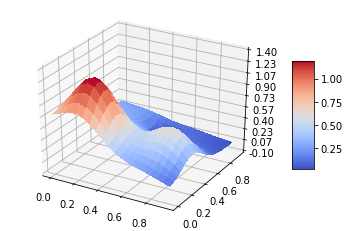

In [3]:
fig = plt.figure()
ax = fig.gca(projection='3d')

# Plot the surface.
surf = ax.plot_surface(x, y, z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-0.10, 1.40)
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [4]:
def CreateDesignMatrix_X(x, y, n = 5):
    if len(x.shape) > 1:
        x = np.ravel(x)
        y = np.ravel(y)
        
    N = len(x)
    l = int((n+1)*(n+2)/2)
    X = np.ones((N,l))
        
    for i in range(1,n+1):
        q = int((i)*(i+1)/2)
        for k in range(i+1):
            X[:,q+k] = x**(i-k) * y**k
    return X

In [5]:
n_x = 1000   # number of points
m = 5        # degree of polynomial

# sort the random values, else your fit will go crazy
x = np.sort((np.random.uniform(0, 1, n_x)))
y = np.sort(np.random.uniform(0, 1, n_x))

# use the meshgrid functionality, very useful
x, y = np.meshgrid(x,y)
z = FrankeFunction(x,y)

#Transform from matrices to vectors
x_1 = np.ravel(x)
y_1 = np.ravel(y)
n = int(len(x_1))
z_1 = np.ravel(z) + np.random.random(n) * 1


# finally create the design matrix
X = CreateDesignMatrix_X(x_1, y_1, n=m)

z_1 is the function that gives the data, X is the design matrix

Then inverse the matrix and find β, and perform the linear regression (where ztilde is the model):

In [6]:
beta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(z_1)
ztilde = X @ beta

In [7]:
ztilde.shape

(1000000,)

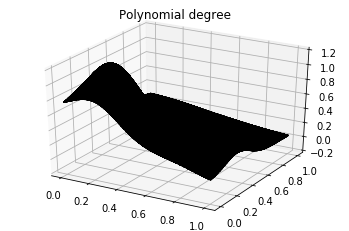

In [8]:
fig = plt.figure()
ax1 = fig.add_subplot(111, projection='3d')
ax1.set_zlim3d(-0.2, 1.2)

#ax1.plot_surface(x, y, z_hat, alpha=0.5, cmap=cm.coolwarm)
ax1.scatter(x, y, z, alpha=1, s=0.1, color='black')

plt.title(f'Polynomial degree')
plt.show()

Find the confidence intervals of the parameters β by computing their variances:

In [9]:
np.var(beta)

602.6707619212381

?????

Next we evaluate the Mean Squared error (MSE) and the R2 score function for the model (ztilde):

In [10]:
def MSE(z_data, z_model):
    n = np.size(z_model)
    return np.sum((z_data-z_model)**2)/n

print(MSE(z_1, ztilde))

0.08539499199733365


The MSE is ideally zero, since the smaller the value the better the fit. Here we observe an MSE of 0.09, which is pretty low, therefore indicating a good fit of the model.

In [11]:
def R2(z_data, z_model):
    return 1 - np.sum((z_data - z_model) ** 2) / np.sum((z_data - np.mean(z_model)) ** 2)

print(R2(z_1, ztilde))

0.48195107987302754


The R2 score gives the coefficient of determination, which indicates how well the model predicts future samples. The best score would be 1.0. Given that the model has a score of 0.5 , this indicates that the model would explain 50% of the future samples correct, which is quite low (not sure if we can say this though).

# Part b) Resampling techniques, adding more complexity

First split the dataset in training data and test data

In [12]:
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [13]:
X_train, X_test, z_train, z_test = train_test_split(X, z_1, test_size=0.2)

In [14]:
# Get the new model from the training data
beta2 = np.linalg.inv(X_train.T.dot(X_train)).dot(X_train.T).dot(z_train)
ztilde1 = X_train @ beta2

# And the predictions for the test data
zpredict = X_test @ beta2

In [15]:
print("Training MSE:")
print(MSE(z_train, ztilde1))

print("Test MSE:")
print(MSE(z_test, zpredict))

Training MSE:
0.08545169604780778
Test MSE:
0.08517020649516126


In [16]:
print("Training R2:")
print(R2(z_train, ztilde1))

print("Test R2:")
print(R2(z_test, zpredict))

Training R2:
0.48173301054778617
Test R2:
0.482810445626077


K-fold cross validation

In [17]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [18]:
# Initialize a KFold instance
k = 10
kfold = KFold(n_splits = k, shuffle=True)

In [22]:
?cross_val_score

Perform the cross-validation to estimate R2 and MSE

In [27]:
import sklearn.linear_model as skl
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score

In [28]:
linreg = skl.LinearRegression().fit(X_train, z_train)
ztilde2 = linreg.predict(X_test)

In [29]:
scores = cross_val_score(linreg, X_test, z_test, cv = kfold)
print(scores)

[0.48100879 0.48965497 0.4770806  0.47966688 0.4696972  0.49170353
 0.4787432  0.48544164 0.48772279 0.48591902]


In [30]:
print("R2-Score: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R2-Score: 0.48 (+/- 0.01)


In [31]:
scores_mse = cross_val_score(linreg, X_test, z_test, scoring='neg_mean_squared_error', cv=5)

In [32]:
estimated_mse_sklearn = np.mean(-scores_mse)
print(estimated_mse_sklearn)

0.08517822418523854


# Part C) Bias-variance tradeoff

# Part D) Ridge Regression on the Franke function with resampling

In [45]:
_lambda = 0.5

In [46]:
betaridge = np.linalg.inv(X.T.dot(X)+(_lambda*np.eye(len(X[0])))).dot(X.T).dot(z_1)
zridge = X @ betaridge

In [47]:
print("var(beta)")
print(np.var(beta))

print("var(betaridge)")
print(np.var(betaridge))

var(beta)
602.6707619212381
var(betaridge)
60.921322537643476


In [50]:
print(MSE(z_1, zridge))

0.08638496777462128


In [49]:
print(R2(z_1, zridge))

0.4759453894890111


In [51]:
#not finished

# Part E) Lasso Regression on the Franke function with resampling


In [33]:
from sklearn.preprocessing import PolynomialFeatures

In [38]:
#polynomial_features = PolynomialFeatures(degree=5)
#X_poly = polynomial_features.fit_transform(X)

In [74]:
clf_lasso = skl.Lasso(alpha=0.001).fit(X_train, z_train)
zlasso = clf_lasso.predict(X_test)

In [75]:
print(MSE(z_test, zlasso))

0.09623587340487058


In [76]:
print(R2(z_test, zlasso))

0.41561428220289043


The smaller alpha gets, the lower the MSE and the higher the R2 score.